In [1]:
import numpy as np 
import pandas as pd 
import pymc3 as pm 
import matplotlib.pyplot as plt 
import arviz 

bd = pd.read_csv('./numpyro/birthdays.txt')

lam_date_join = lambda row: f"{row['year']}-{row['month']}-{row['day']}"
bd["date"] = pd.to_datetime(bd.apply(lam_date_join, axis=1), format="%Y-%m-%d")

lam_get_day = lambda date: date.days

bd_sm = bd[bd["year"] <= 1970]
bd_sm['date_indexed'] = (bd_sm['date'] - bd_sm['date'].min()).apply(lam_get_day)
# bd_sm['date_normed'] = (bd_sm['date_indexed'] - bd_sm['date_indexed'].mean()) / bd_sm['date_indexed'].std()
bd_sm['births_normed'] = (bd_sm['births'] - bd_sm['births'].mean()) / bd_sm['births'].std()

# date_scale = 1/bd_sm['date_indexed'].std() # one day corresps to date_scale normed days

bd_sm['date_normed'] = bd_sm['date_indexed']
# bd_sm['births_normed'] = bd_sm['births']

In [2]:
# add in the special days

# get the day of the week (used for some holidays)
n_weeks = int(np.ceil(bd_sm.shape[0] / 7))
bd_sm["weekdays"] = pd.Series(["Wed","Thr","Fri","Sat","Sun","Mon","Tue"] * n_weeks)

def find_holiday(df: pd.DataFrame, month: int, weekday: str, n: int):
    """
        Get indicator column for holiday which occurs on
        n-th weekday of month. (n=-1 for last)
    """
    indic = pd.Series(0, df.index) 
    hols = df.query(f"month == {month} and weekdays == '{weekday}'").groupby(by=['year']).nth(n=n)
    for j in range(hols.shape[0]): # for each one...
        j_date = hols.iloc[j]["date"] # ...get the date...
        indic[df["date"]==j_date] = 1 # ...and record it

    return indic

bd_sm["spd_newyears"] = ((bd_sm["month"] == 1) & (bd_sm["day"] == 1)).astype(int)
bd_sm["spd_val"] = ((bd_sm["month"] == 2) & (bd_sm["day"] == 14)).astype(int)
bd_sm["spd_leap"] = ((bd_sm["month"] == 2) & (bd_sm["day"] == 29)).astype(int)
bd_sm["spd_aprilf"] = ((bd_sm["month"] == 4) & (bd_sm["day"] == 1)).astype(int)
bd_sm["spd_memorial"] = find_holiday(bd_sm, month=5, weekday='Mon', n=-1) 
bd_sm["spd_indep"] = ((bd_sm["month"] == 7) & (bd_sm["day"] == 4)).astype(int)
bd_sm["spd_labor"] = find_holiday(bd_sm, month=9, weekday='Mon', n=0) 
bd_sm["spd_halloween"] = ((bd_sm["month"] == 10) & (bd_sm["day"] == 31)).astype(int)
bd_sm["spd_thanks"] = find_holiday(bd_sm, month=11, weekday='Thr', n=3)
bd_sm["spd_xmas"] = ((bd_sm["month"] == 12) & (bd_sm["day"] == 25)).astype(int)


In [3]:
bd_sm.head(4)

year  month  day  births  day_of_year  day_of_week       date  \
0  1969      1    1    8486            1            3 1969-01-01   
1  1969      1    2    9002            2            4 1969-01-02   
2  1969      1    3    9542            3            5 1969-01-03   
3  1969      1    4    8960            4            6 1969-01-04   

   date_indexed  births_normed  date_normed  ... spd_newyears  spd_val  \
0             0      -1.861677            0  ...            1        0   
1             1      -1.245677            1  ...            0        0   
2             2      -0.601027            2  ...            0        0   
3             3      -1.295817            3  ...            0        0   

   spd_leap  spd_aprilf  spd_memorial  spd_indep  spd_labor  spd_halloween  \
0         0           0             0          0          0              0   
1         0           0             0          0          0              0   
2         0           0             0          0          0              0   
3         0           0             0          0          0              0   

   spd_thanks  spd_xmas  
0           0         0  
1           0         0  
2           0         0  
3           0         0  

[4 rows x 21 columns]

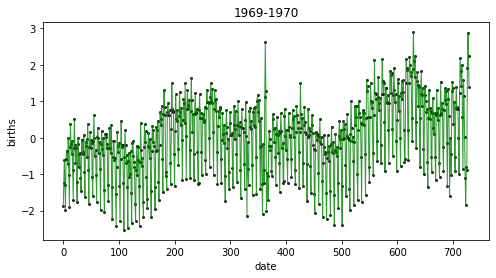

In [4]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(bd_sm['date_normed'], bd_sm['births_normed'], alpha=0.8, color='g', lw=1)
ax.scatter(bd_sm['date_normed'], bd_sm['births_normed'], alpha=0.8, color='k', s=4)
ax.set(xlabel="date", ylabel="births", title="1969-1970")
plt.show()

Let's build some Gaussian process priors which can nicely match this data. Clearly there are several scales of periodicity here, probably weekly, monthly, and yearly. There are also short-term and long-term fluctuations from that trend. Each one of these behaviors will be represented as its own GP, the sum total of which will give rise to the overall function. See the Gelman BDA book for his listing of these terms.

The periodic patterns will be similar to each other in form, but will differ in their parameters. We could hard-code the weekly pattern to have a period of $7$ days, but the Bayesian approach would be to specify a prior distribution over the period parameter which is tight around $7$, to allow for some leeway.

## Note: do on original time scale so the priors make sense

In [49]:
# X = bd_sm['date_normed'].values[:300,None]
# y = bd_sm['births_normed'].values[:300,None]

X = bd_sm[['date_normed', 'spd_newyears', 'spd_val', 'spd_leap', 'spd_aprilf',
    'spd_memorial','spd_indep','spd_labor','spd_halloween','spd_thanks',
    'spd_xmas']].values[:300,:]
y = bd_sm['births_normed'].values[:300,None]



# kernel_long = .8**2 * pm.gp.cov.ExpQuad(1, ls=200) # need to multiply by the variance
# kernel_short = .8**2 * pm.gp.cov.ExpQuad(1, ls=800)
# kernel_week = .8**2 * pm.gp.cov.ExpQuad(1,ls=2) * pm.gp.cov.Periodic(1, period=7, ls=2)
# kernel_year = .8**2 * pm.gp.cov.ExpQuad(1, ls=400) * pm.gp.cov.Periodic(1, period=365, ls=400)

with pm.Model() as model:
    # GP1: long-term trends. Squared-exponential covariance function
    length_long = pm.Normal('length_long',365,1.)
    sigma_long = pm.Normal('sigma_long', .7,.1)
    # kernel
    kernel_long = sigma_long**2 * pm.gp.cov.ExpQuad(1, length_long, active_dims=[0]) # need to multiply by the variance
    # Gaussian process prior 1
    f_1 = pm.gp.Marginal(cov_func=kernel_long) # mean 0 by default

    # GP2: short-term trends. Squared-exponential covariance function
    # parameter priors
    length_short = pm.Normal('length_short',10,.1) # smaller length scale
    sigma_short = pm.Normal('sigma_short', 0.4,.1)
    # kernel
    kernel_short = sigma_short**2 * pm.gp.cov.ExpQuad(1, length_short, active_dims=[0])
    # Gaussian process prior 1
    f_2 = pm.gp.Marginal(cov_func=kernel_short)

    # GP3: weekly trend squared exp * periodic ("local periodic kernel")
    length_week = pm.Normal('length_week', 20, .5) # length scale of exp envelope
    ls_period_week = pm.Normal('ls_period_week', 2, .2) # 1/ls is amplitude of the periodic part
    sigma_week = pm.Normal('sigma_week', 0.2,0.02)
    kernel_week = sigma_week**2 * pm.gp.cov.ExpQuad(1, length_week, active_dims=[0]) \
        * pm.gp.cov.Periodic(1, period=7, ls=ls_period_week, active_dims=[0])
    f_3 = pm.gp.Marginal(cov_func=kernel_week)

    # GP4: yearly trend
    length_year = pm.Normal('length_year',1000,100)
    ls_period_year = pm.Normal('ls_period_year',100,10)
    sigma_year = pm.Normal('sigma_year', 2.,.2)
    kernel_year = sigma_year**2 * pm.gp.cov.ExpQuad(1, length_year, active_dims=[0]) \
        * pm.gp.cov.Periodic(1, period=365.25, ls=ls_period_year, active_dims=[0])
    f_4 = pm.gp.Marginal(cov_func=kernel_year)


    # GP5: special days (weekend not implemented)
    # there are 10 special days, so 10 indicator variables for each sample => 10 parameters needed (coefficients)
    # beta = pm.Normal("beta", 0, 2, shape=(1,10)) # coefficients
    # mean_special = pm.gp.mean.Linear(coeffs=beta)
    # f_5 = pm.gp.Marginal(mean_func=mean_special)
    beta = pm.Normal('beta_1',0, 3.,)
    k1 = beta.T * pm.gp.cov.Linear(10, c=0, active_dims=[2]) # remaining columns of X
    f_5 = pm.gp.Marginal(cov_func=k1)






    # observation noise
    sigma_noise = pm.HalfCauchy('sigma_noise', .1)

    # total Gaussian process
    gp = f_1 + f_2 + f_3 + f_4 + f_5

    # marginal likelihood: where the observations come into play
    y_ = gp.marginal_likelihood('y_obs', X=X, y=y.squeeze(), noise=sigma_noise, is_observed=True)


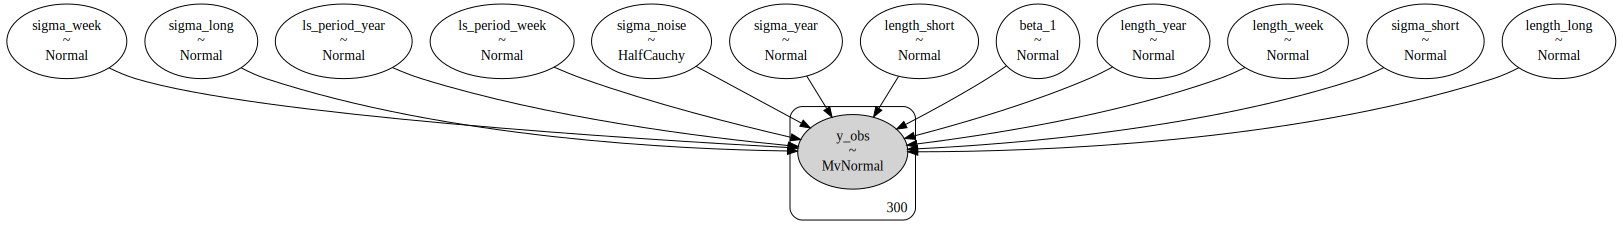

In [50]:
pm.model_to_graphviz(model)

# Do prior predictive simulations to see if priors make sense!

The kernels need to have constant parameters --- can't have priors over them. Pick values and try to get close. Later, set my priors on the parameters about these values.

In [7]:
# kernel_long = .8**2 * pm.gp.cov.ExpQuad(1, ls=200) # need to multiply by the variance
# kernel_short = .8**2 * pm.gp.cov.ExpQuad(1, ls=800)
# kernel_week = .8**2 * pm.gp.cov.ExpQuad(1,ls=2) * pm.gp.cov.Periodic(1, period=7, ls=2)
# kernel_year = .8**2 * pm.gp.cov.ExpQuad(1, ls=400) * pm.gp.cov.Periodic(1, period=365, ls=400)

# kernel =  kernel_long + kernel_short + kernel_week + kernel_year

# Xnew = np.linspace(1,600,600)[:,None]
# cov=kernel(Xnew).eval()

# sampl = np.random.multivariate_normal(mean=np.zeros_like(Xnew).flatten(), cov=cov, size=(3,))

# fig, ax = plt.subplots()
# ax.scatter(bd_sm['date_normed'], bd_sm['births_normed'], alpha=0.3, color='k', s=4)
# ax.plot(Xnew, sampl.T)

# plt.show()

# Fit the model to determine plausible parameter values

In [51]:
# sample from the model posteriors to get posterior distributions ("plausibility") for the kernel parameters
with model:
    mp = pm.find_MAP()
    # trace = pm.sample(2000) 
    # advi_fit = pm.fit(method='svgd', n=2000, obj_optimizer=pm.adagrad(learning_rate=1e-1))

In [9]:
# import pickle

# with open('model_trace.pkl', 'wb') as fout:
#     pickle.dump((model,trace), fout)

In [10]:
# import pickle

# with open('model_trace.pkl', 'rb') as fin:
#     model, trace = pickle.load(fin)

In [52]:
parameters = ['length_long', 'sigma_long', 'length_short', 'sigma_short', 'length_week', 'ls_period_week', 
    'sigma_week', 'length_year', 'ls_period_year', 'sigma_year', 'beta_1'
    ]
val_at_map = [float(mp[param]) for param in parameters]

for idx in range(len(parameters)):
    print("{0:<15}    {1:>10.4}".format(parameters[idx], val_at_map[idx]))

length_long             365.0
sigma_long              0.705
length_short            9.999
sigma_short           -0.1403
length_week             20.87
ls_period_week         0.3337
sigma_week             0.3408
length_year             1e+03
ls_period_year          100.0
sigma_year              1.992
beta_1                 0.2537


In [27]:
# # plt.hist(trace['period_year'],bins=60)
# plt.plot(trace['beta_1'])
# plt.show()

How to sample from individual GP components?

In [53]:
# X_new = np.linspace(1, 300, 300)[:,None]

# to sample at new data points, with special days, we need special day
# features (these are part of the input space)
# I'm just going to use the 
X_new = bd_sm[['date_normed', 'spd_newyears', 'spd_val', 'spd_leap', 'spd_aprilf',
    'spd_memorial','spd_indep','spd_labor','spd_halloween','spd_thanks',
    'spd_xmas']].values[:300,:]

with model:
    # get conditional distribution on different components
    f_long = f_1.conditional('f_long', X_new,
        given={"X":X, "y":y.squeeze(), "noise": sigma_noise, "gp": gp})

    f_short = f_2.conditional('f_short', X_new,
        given={"X":X, "y":y.squeeze(), "noise": sigma_noise, "gp": gp})

    f_week = f_3.conditional('f_week', X_new,
        given={"X":X, "y":y.squeeze(), "noise": sigma_noise, "gp": gp})

    f_year = f_4.conditional('f_year', X_new,
        given={"X":X, "y":y.squeeze(), "noise": sigma_noise, "gp": gp})

    f_spd = f_5.conditional('f_spd', X_new,
        given={"X":X, "y":y.squeeze(), "noise": sigma_noise, "gp": gp})

    f = gp.conditional("f_star", X_new)

In [54]:
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_long, f_short, f_week, f_year, f_spd, f], samples=400)
    # pred_samples = pm.sample_posterior_predictive(trace, vars=[f_long, f_short,f_week, f_year, f], samples=1000)

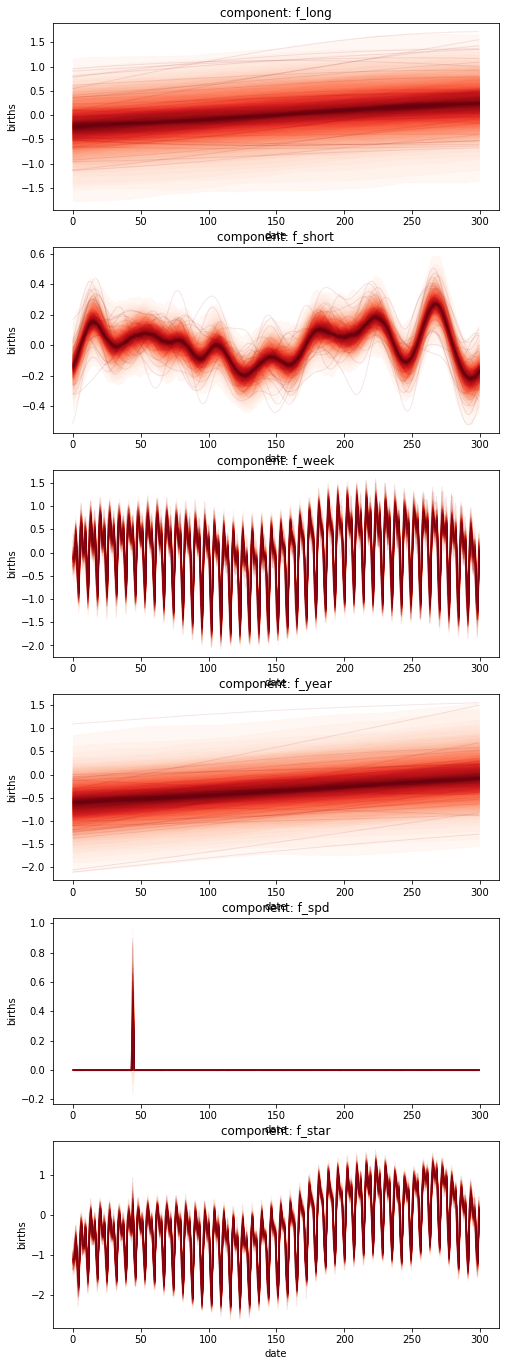

In [55]:
fig, ax = plt.subplots(nrows=6,figsize=(8,24))

N=300
# ax.plot(bd_sm['date_normed'][:N], bd_sm['births_normed'][:N], alpha=0.4, color='g', lw=1)
# ax.scatter(bd_sm['date_normed'], bd_sm['births_normed'], alpha=0.8, color='k', s=4)
from pymc3.gp.util import plot_gp_dist


for idx,cmpt in enumerate(['f_long', 'f_short','f_week', 'f_year', 'f_spd','f_star']):
    plot_gp_dist(ax[idx], pred_samples[cmpt], X_new[:,0])
    ax[idx].set(xlabel="date", ylabel="births", title=f"component: {cmpt}")

plt.show()

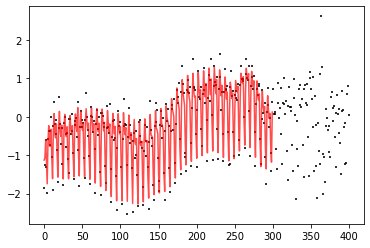

In [60]:

fig, ax = plt.subplots(figsize=(6,4))

plt.plot(X_new[:,0], np.mean(pred_samples['f_star'],axis=0), c='r', alpha=0.7)

ax.scatter(bd_sm['date_normed'][:400], bd_sm['births_normed'][:400], alpha=0.8, color='k', s=4, marker='+')
# ax.set(xlabel="date", ylabel="births", title="1969-1970")


plt.show()

In [59]:
X_new.shape

(300, 11)